# Building a neural network classifier using numpy

This is an original implementation of a neural network classifier using numpy.  Given a 2-D matrix of features and a corresponding set of labels, the **neuralNet** function is able to generate a classification model.  We first define several helper functions to calculate the gradient at each step, evaluate the cost function, make classifications, evaluate the sigmoid function, and split data into randomized batches.  We then show how to use **neuralNet** to classify digits from the MNIST dataset.  Each function's docstring describes its use.

In [1]:
import numpy as np
import mnist
import matplotlib.pyplot as plt

In [2]:
def sig(z):
    """ Return f(z) where f is the sigmoid function. """

    return 1. / (1 + np.exp(-1*z))

In [3]:
def classify(X, weights, training = True):
    """
    Return the relative likelihoods of each class for the given items.
    
    Parameters
    ----------
    X : array[n x m]
        2-D feature matrix with n items and m features per item.
    weights : list
        The trained weights (obtained from neuralNet).
    training : boolean
        Default True.  Set to False if you are using this outside of the neuralNet function.


    Returns
    -------
    hypothesis : array[n x c]
        2-D matrix of hypotheses for each given item of X, where c is the number of classes.
        Entry [i,j] contains the probabilty that item i is class j.  Use
        np.argmax(hypothesis, axis=1) to get a 1-D array of predicted labels.
    """

    n = X.shape[0]
    lengthWeights = len(weights)
    
    if training == False:
        X = np.hstack((np.ones((n, 1)), X))

    aMat = []
    z = np.matmul(weights[0], np.transpose(X))
    aMat.append(np.transpose(np.vstack((np.ones((1, n)), sig(z)))))
    for i in range(1, lengthWeights):
        z = np.matmul(weights[i], np.transpose(aMat[i-1]))
        aMat.append(np.transpose(np.vstack((np.ones((1, n)), sig(z)))))

    return aMat[-1][:,1:]

In [4]:
def calcCost(X, Y, weights, regLambda):
    """Calculate the value of the cross entropy cost function. """
    
    n = X.shape[0]
    numClass = Y.shape[1]
    hypothesis = classify(X, weights)
    
    ## Calculate the cost due to error
    cost = 0
    for i in range(n):
        for k in range(numClass):
            cost += ( -1 * Y[i,k]*np.log(hypothesis[i,k]) - (1 - Y[i,k])*np.log(1 - hypothesis[i,k]) )
    cost = cost / n
    
    ##Calculate the cost due to regularization
    regCost = 0
    for B in range(len(weights)):
        regCost += np.sum(weights[B][:,1:] ** 2)
    regCost = (regCost * regLambda) / (2*n)
    
    ## Total cost is the sum of error plus regularization
    return (cost + regCost)

In [5]:
def calcGrad(X, Y, weights, regLambda):
    """Calculate the gradient of the parameters with respect to the cost function. """
    
    n = X.shape[0]
    lengthWeights = len(weights)
    
    ## Calculate each activation value
    aMat = []
    z = np.matmul(weights[0], np.transpose(X))
    aMat.append(np.transpose(np.vstack((np.ones((1, n)), sig(z)))))
    for i in range(1, lengthWeights):
        z = np.matmul(weights[i], np.transpose(aMat[i-1]))
        aMat.append(np.transpose(np.vstack((np.ones((1, n)), sig(z)))))
    aMat[-1] = aMat[-1][:,1:]
    
    ## Calculate deltas for use in backprop
    deltaMat = [[]]*lengthWeights
    deltaMat[-1] = aMat[-1] - Y
    for i in range(lengthWeights-2, -1, -1):
        deltaMat[i] = np.transpose(np.matmul(np.transpose(weights[i+1]), np.transpose(deltaMat[i+1]))) * \
                     (aMat[i] * (np.ones(aMat[i].shape) - aMat[i]))
        deltaMat[i] = deltaMat[i][:,1:]
    
    ## Use activation and delta values to calulate the gradient
    grad = []
    grad.append(np.matmul(np.transpose(deltaMat[0]), X))
    for i in range(1, lengthWeights):
        grad.append(np.matmul(np.transpose(deltaMat[i]), aMat[i-1]))
    
    ## Adjust for regularization
    for i in range(lengthWeights):
        grad[i][:,1:] += regLambda * weights[i][:,1:]
        grad[i] = grad[i] / n
    
    return grad

In [6]:
def makeBatches(n, batchSize = 128):
    """Create randomized minibatches of a given size. """
    
    miniBatches = []
    permutation = list(np.random.permutation(n))
    numCompleteBatches = int(np.floor(n / batchSize))
    for k in range(numCompleteBatches):
        miniBatches.append(permutation[k*batchSize:(k+1)*batchSize])
    if n % batchSize != 0:
        numMissing = n - numCompleteMinibatches*batchSize
        miniBatches.append(permutation[-numMissing:])
    return miniBatches

In [7]:
def neuralNet(X, Y, layers, numEpochs, regLambda = .001, learnRate = .01, batchSize = 100, hot = False, weights_in = []):
    """
    Trains a fully connected neural network.

    Train a fully connected neural network using stochastic gradient descent with minibatches to
    optimize a cross entropy loss function.  Backpropagation helps to calculate the gradient for
    each training step.  The sigmoid activation function is used for all layers.  The user is able
    to specify an L-2 regularization parameter, the minibatch size, the learning rate, and the number
    of training epochs.  There is also functionality for hot runs using pre-trained weights.
    
    Parameters
    ----------
    X : array[n x m]
        2-D feature matrix with n items and m features per item.
    Y : array[n x c]
        2-D label matrix with n items from c possible classes.  Should use one-hot encoding.
    layers : list
        A list specifiying the number and size of the hidden layers.  For example, to create a network
        with two hidden layers of size 200 and 100 (in that order), then set layers = [200, 100].
    numEpochs : int
        Number of epochs to train the network for.  An epoch uses each training example exactly once.
    regLambda : float
        Default .001.  L-2 regularization parameter.  Set equal to 0 to disable regularization.
    batchSize : int
        Default 100.  The size of each minibatch used in SGD.
    hot : boolean
        Default False.  Indicates if weights are provided (True) or if randomized weights are
        to be used (False).
    weights_in : list
        Default [].  Trained weights from a prior run.  If pretrained weights are to be used, then hot
        must be set to True.
    

    Returns
    -------
    weights : list
        The trained weights.  Use with the classify function to generate labels for given items.
    costs : list
        The value of the cost function evaluated at the end of each epoch.  len(costs) == numEpochs.

    """
    n = X.shape[0]
    numFeatures = X.shape[1]
    numClass = Y.shape[1]
    
    ## Add bias term
    X = np.hstack((np.ones((n, 1)), X))
    
    ## Initialize weights (or take pre-trained weights if it's a hot run)
    weights = []
    if hot == True:
        weights = weights_in
    else:
        allLayers = [numFeatures] + layers + [numClass]
        for i in range(len(allLayers) - 1):
            weights.append((2 * np.random.uniform(size=(allLayers[i+1], allLayers[i]+1)) - 1) * (1. / np.sqrt(allLayers[i])))
    
    ## Perform stochastic gradient descent
    costs = []
    for epoch in range(numEpochs):
        cost = 0
        batches = makeBatches(n, batchSize = batchSize)
        for batch in batches:
            grad = calcGrad(X[batch, :], Y[batch, :], weights, regLambda)
            for k in range(len(weights)):
                weights[k] -= learnRate*grad[k]
            cost += calcCost(X[batch, :], Y[batch, :], weights, regLambda) / len(batches)
        costs.append(cost)
        print("Finished " + str(epoch+1) + " out of " + str(numEpochs) + " epochs.  Cost: " + str(cost))
    
    return weights, costs

## 1. Read in the MNIST data

First, we read the MNIST data and save it into numpy arrays.  Each record is a 28x28 pixel image of a handwritten digit.  We flatten the images to form our 2-D feature matrices.  Training and testing sets are given explicitly, so there is no need for us to make a split.  The labels are given as a 1-D array, which we use to form 2-D one-hot encoded label arrays.  The only pre-processing we do is to scale the pixel values.  Given values are in the range of 0 to 255, so we scale each value by (1/255).

In [8]:
trainImages = mnist.train_images().reshape(60000, 28**2) / 255.
trainLabelsFlat = mnist.train_labels()
testImages = mnist.test_images().reshape(10000, 28**2) / 255.
testLabelsFlat = mnist.test_labels()

trainLabels = np.zeros((60000, 10))
testLabels = np.zeros((10000, 10))
trainLabels[np.arange(60000), trainLabelsFlat] = 1
testLabels[np.arange(10000), testLabelsFlat] = 1

## 2. Train a neural network classifier

Using our images and labels, we train a neural network to classifier.  We specifiy that we want:
 - Two fully connected hidden layers.  The first has 400 nodes, and the second has 50 nodes.
 - Train for 40 epochs.
 - Use an L-2 regularization parameter of .001
 - Use a learning rate of 1
 - Set the batch size to 100 (meaning there will be 600 batches per training epoch)

In [9]:
weights, costs_1 = neuralNet(trainImages,
                             trainLabels,
                             layers = [400,50],
                             numEpochs = 40,
                             regLambda = .001,
                             learnRate = 1,
                             batchSize = 100)

Finished 1 out of 40 epochs.  Cost: 1.5389978346111362
Finished 2 out of 40 epochs.  Cost: 0.4160876703139998
Finished 3 out of 40 epochs.  Cost: 0.27727000840114374
Finished 4 out of 40 epochs.  Cost: 0.2046831780994333
Finished 5 out of 40 epochs.  Cost: 0.15902820652174426
Finished 6 out of 40 epochs.  Cost: 0.12997450728842164
Finished 7 out of 40 epochs.  Cost: 0.10850111618517745
Finished 8 out of 40 epochs.  Cost: 0.09353711724978815
Finished 9 out of 40 epochs.  Cost: 0.08188165666110093
Finished 10 out of 40 epochs.  Cost: 0.07215910305149471
Finished 11 out of 40 epochs.  Cost: 0.0640160309216756
Finished 12 out of 40 epochs.  Cost: 0.05890813332896807
Finished 13 out of 40 epochs.  Cost: 0.05348004161705373
Finished 14 out of 40 epochs.  Cost: 0.049381636291995525
Finished 15 out of 40 epochs.  Cost: 0.046518528434378294
Finished 16 out of 40 epochs.  Cost: 0.04381537296014138
Finished 17 out of 40 epochs.  Cost: 0.04158499497374391
Finished 18 out of 40 epochs.  Cost: 0.039

## 3. Plot the cost function (phase 1)

We can see that the cost function appears to be improving each epoch, so let's plot it:

Text(0.5, 1.0, 'Value of cost function (first phase)')

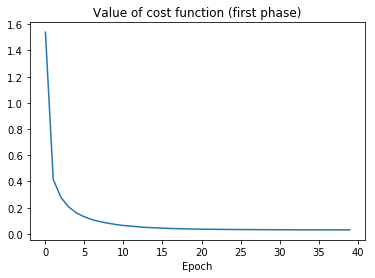

In [15]:
plt.plot(costs_1)
plt.xlabel("Epoch")
plt.title("Value of cost function (first phase)")

## 4. Fine tuning

Let's use **neuralNet**'s ability to take pre-trained weights and do some fine tuning.  We will decrease the learning rate by a factor of 10 and train for another 40 epochs.

In [10]:
weights, costs_2 = neuralNet(trainImages,
                             trainLabels,
                             layers = [400,50],
                             numEpochs = 40,
                             regLambda = .001,
                             learnRate = .1,
                             batchSize = 100,
                             hot = True,
                             weights_in = weights)

Finished 1 out of 40 epochs.  Cost: 0.03171031977792799
Finished 2 out of 40 epochs.  Cost: 0.03158667371820139
Finished 3 out of 40 epochs.  Cost: 0.031550871808612574
Finished 4 out of 40 epochs.  Cost: 0.03151721714276342
Finished 5 out of 40 epochs.  Cost: 0.03149563755002712
Finished 6 out of 40 epochs.  Cost: 0.031473671314591126
Finished 7 out of 40 epochs.  Cost: 0.03145794520941362
Finished 8 out of 40 epochs.  Cost: 0.03144589538350334
Finished 9 out of 40 epochs.  Cost: 0.031424606782286035
Finished 10 out of 40 epochs.  Cost: 0.03141200466194094
Finished 11 out of 40 epochs.  Cost: 0.03139340545970976
Finished 12 out of 40 epochs.  Cost: 0.031375225358035594
Finished 13 out of 40 epochs.  Cost: 0.03136476122708967
Finished 14 out of 40 epochs.  Cost: 0.03134752991933193
Finished 15 out of 40 epochs.  Cost: 0.03133527804158773
Finished 16 out of 40 epochs.  Cost: 0.031316285341335175
Finished 17 out of 40 epochs.  Cost: 0.031300536650286974
Finished 18 out of 40 epochs.  Cos

## 5. Plot the cost function (phase 2)

We can see that the cost function is still improving, albeit slowly.  It hasn't levelled out so we could potentially do even more fine tuning.

Text(0.5, 1.0, 'Value of cost function (second phase)')

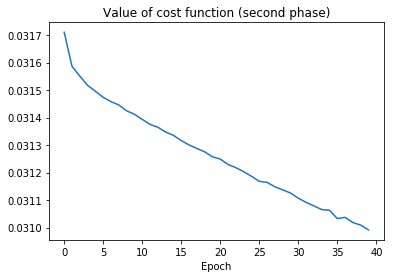

In [13]:
plt.plot(costs_2)
plt.xlabel("Epoch")
plt.title("Value of cost function (second phase)")

## 6. Measure the training and validation accuracy

Using our trained model, we get near 100% accuracy on the training set and 98.3% accuracy on the validation set.  We know that the most sophistocated models achieve 99.8% accuracy, so our very simple model that uses minimal preprocesing, no convulation layers, and sigmoid activations only lags by 1.5%.

In [14]:
predTrainLabels = np.argmax(classify(trainImages, weights, training = False), axis=1)
predTestLabels = np.argmax(classify(testImages, weights, training = False), axis=1)
numCorrectTrain = np.sum(predTrainLabels == trainLabelsFlat)
numCorrectTest = np.sum(predTestLabels == testLabelsFlat)
print("Training accuracy: " + str(numCorrectTrain / len(trainLabelsFlat)))
print("Validation accuracy: " + str(numCorrectTest / len(testLabelsFlat)))

Training accuracy: 0.9999833333333333
Validation accuracy: 0.983
